In [217]:
import pandas as pd
from google.colab import files

# Read csv
df = pd.read_csv('Task 3 and 4_Loan_Data.csv')
df.head(10)

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0
5,4661159,0,5376.886873,7189.121298,85529.84591,2,697,0
6,8291909,1,3634.057471,7085.980095,68691.57707,6,722,0
7,4616950,4,3302.172238,13067.570210,50352.16821,3,545,1
8,3395789,0,2938.325123,1918.404472,53497.37754,4,676,0
9,4045948,0,5396.366774,5298.824524,92349.55399,2,447,0


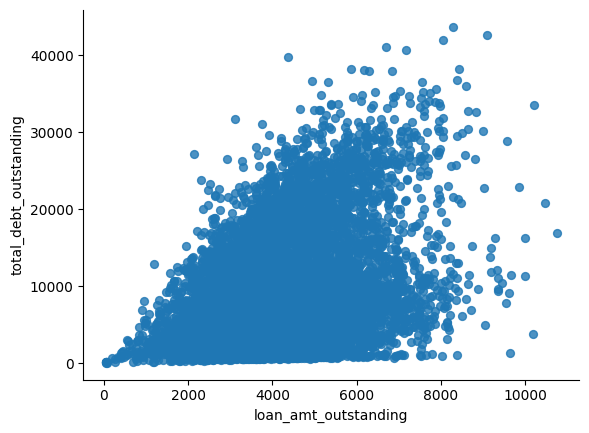

In [218]:
# @title loan_amt_outstanding vs total_debt_outstanding

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='loan_amt_outstanding', y='total_debt_outstanding', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

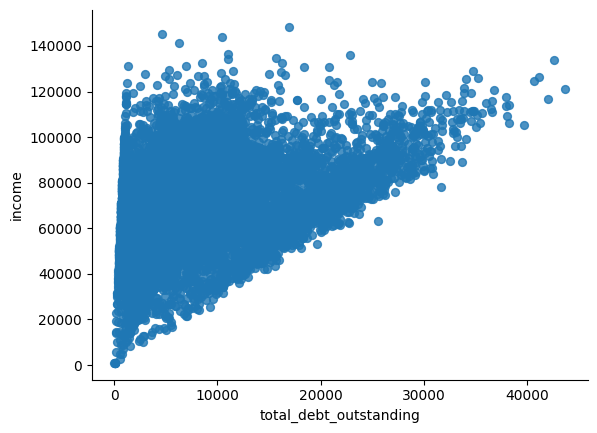

In [219]:
# @title total_debt_outstanding vs income

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='total_debt_outstanding', y='income', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [220]:
for column in df.columns:
  print(df[column].value_counts())


customer_id
8153374    1
5691318    1
8004391    1
8279945    1
4994632    1
          ..
2808070    1
1690401    1
4526793    1
6551962    1
5533570    1
Name: count, Length: 10000, dtype: int64
credit_lines_outstanding
0    4128
1    2590
5    1297
2     902
3     599
4     484
Name: count, dtype: int64
loan_amt_outstanding
5221.545193    1
5485.781986    1
4449.962140    1
4510.196971    1
4247.262415    1
              ..
2718.223058    1
1806.562618    1
4892.724179    1
3733.583919    1
1917.652480    1
Name: count, Length: 10000, dtype: int64
total_debt_outstanding
3915.471226     1
8401.561404     1
10433.127520    1
6825.866905     1
5296.831094     1
               ..
531.956363      1
3767.466415     1
7944.065716     1
15051.195920    1
3050.248203     1
Name: count, Length: 10000, dtype: int64
income
1000.00000     6
86032.93789    1
76547.88432    1
35474.54524    1
25346.59770    1
              ..
32743.50295    1
79863.38239    1
58405.68556    1
75759.76725    1
30611

In [221]:
df.dtypes

customer_id                   int64
credit_lines_outstanding      int64
loan_amt_outstanding        float64
total_debt_outstanding      float64
income                      float64
years_employed                int64
fico_score                    int64
default                       int64
dtype: object

In [222]:
# Create new features
df['debt_to_income_ratio'] = df['total_debt_outstanding'] / df['income']
df['credit_utilization_rate'] = np.where(df['credit_lines_outstanding'] == 0,0,df['loan_amt_outstanding'] / df['credit_lines_outstanding'])
df['debt_repayment_ability_ratio'] = (df['income'] - df['total_debt_outstanding']) / df['income']
df['years_employed_per_loan'] = df['years_employed'] / df['total_debt_outstanding']
df['income_per_credit_line'] = np.where(df['credit_lines_outstanding'] == 0,0,df['income'] / df['credit_lines_outstanding'])
df['loan_amt_to_income_ratio'] = df['loan_amt_outstanding'] / df['income']
df.isnull().sum()

customer_id                     0
credit_lines_outstanding        0
loan_amt_outstanding            0
total_debt_outstanding          0
income                          0
years_employed                  0
fico_score                      0
default                         0
debt_to_income_ratio            0
credit_utilization_rate         0
debt_repayment_ability_ratio    0
years_employed_per_loan         0
income_per_credit_line          0
loan_amt_to_income_ratio        0
dtype: int64

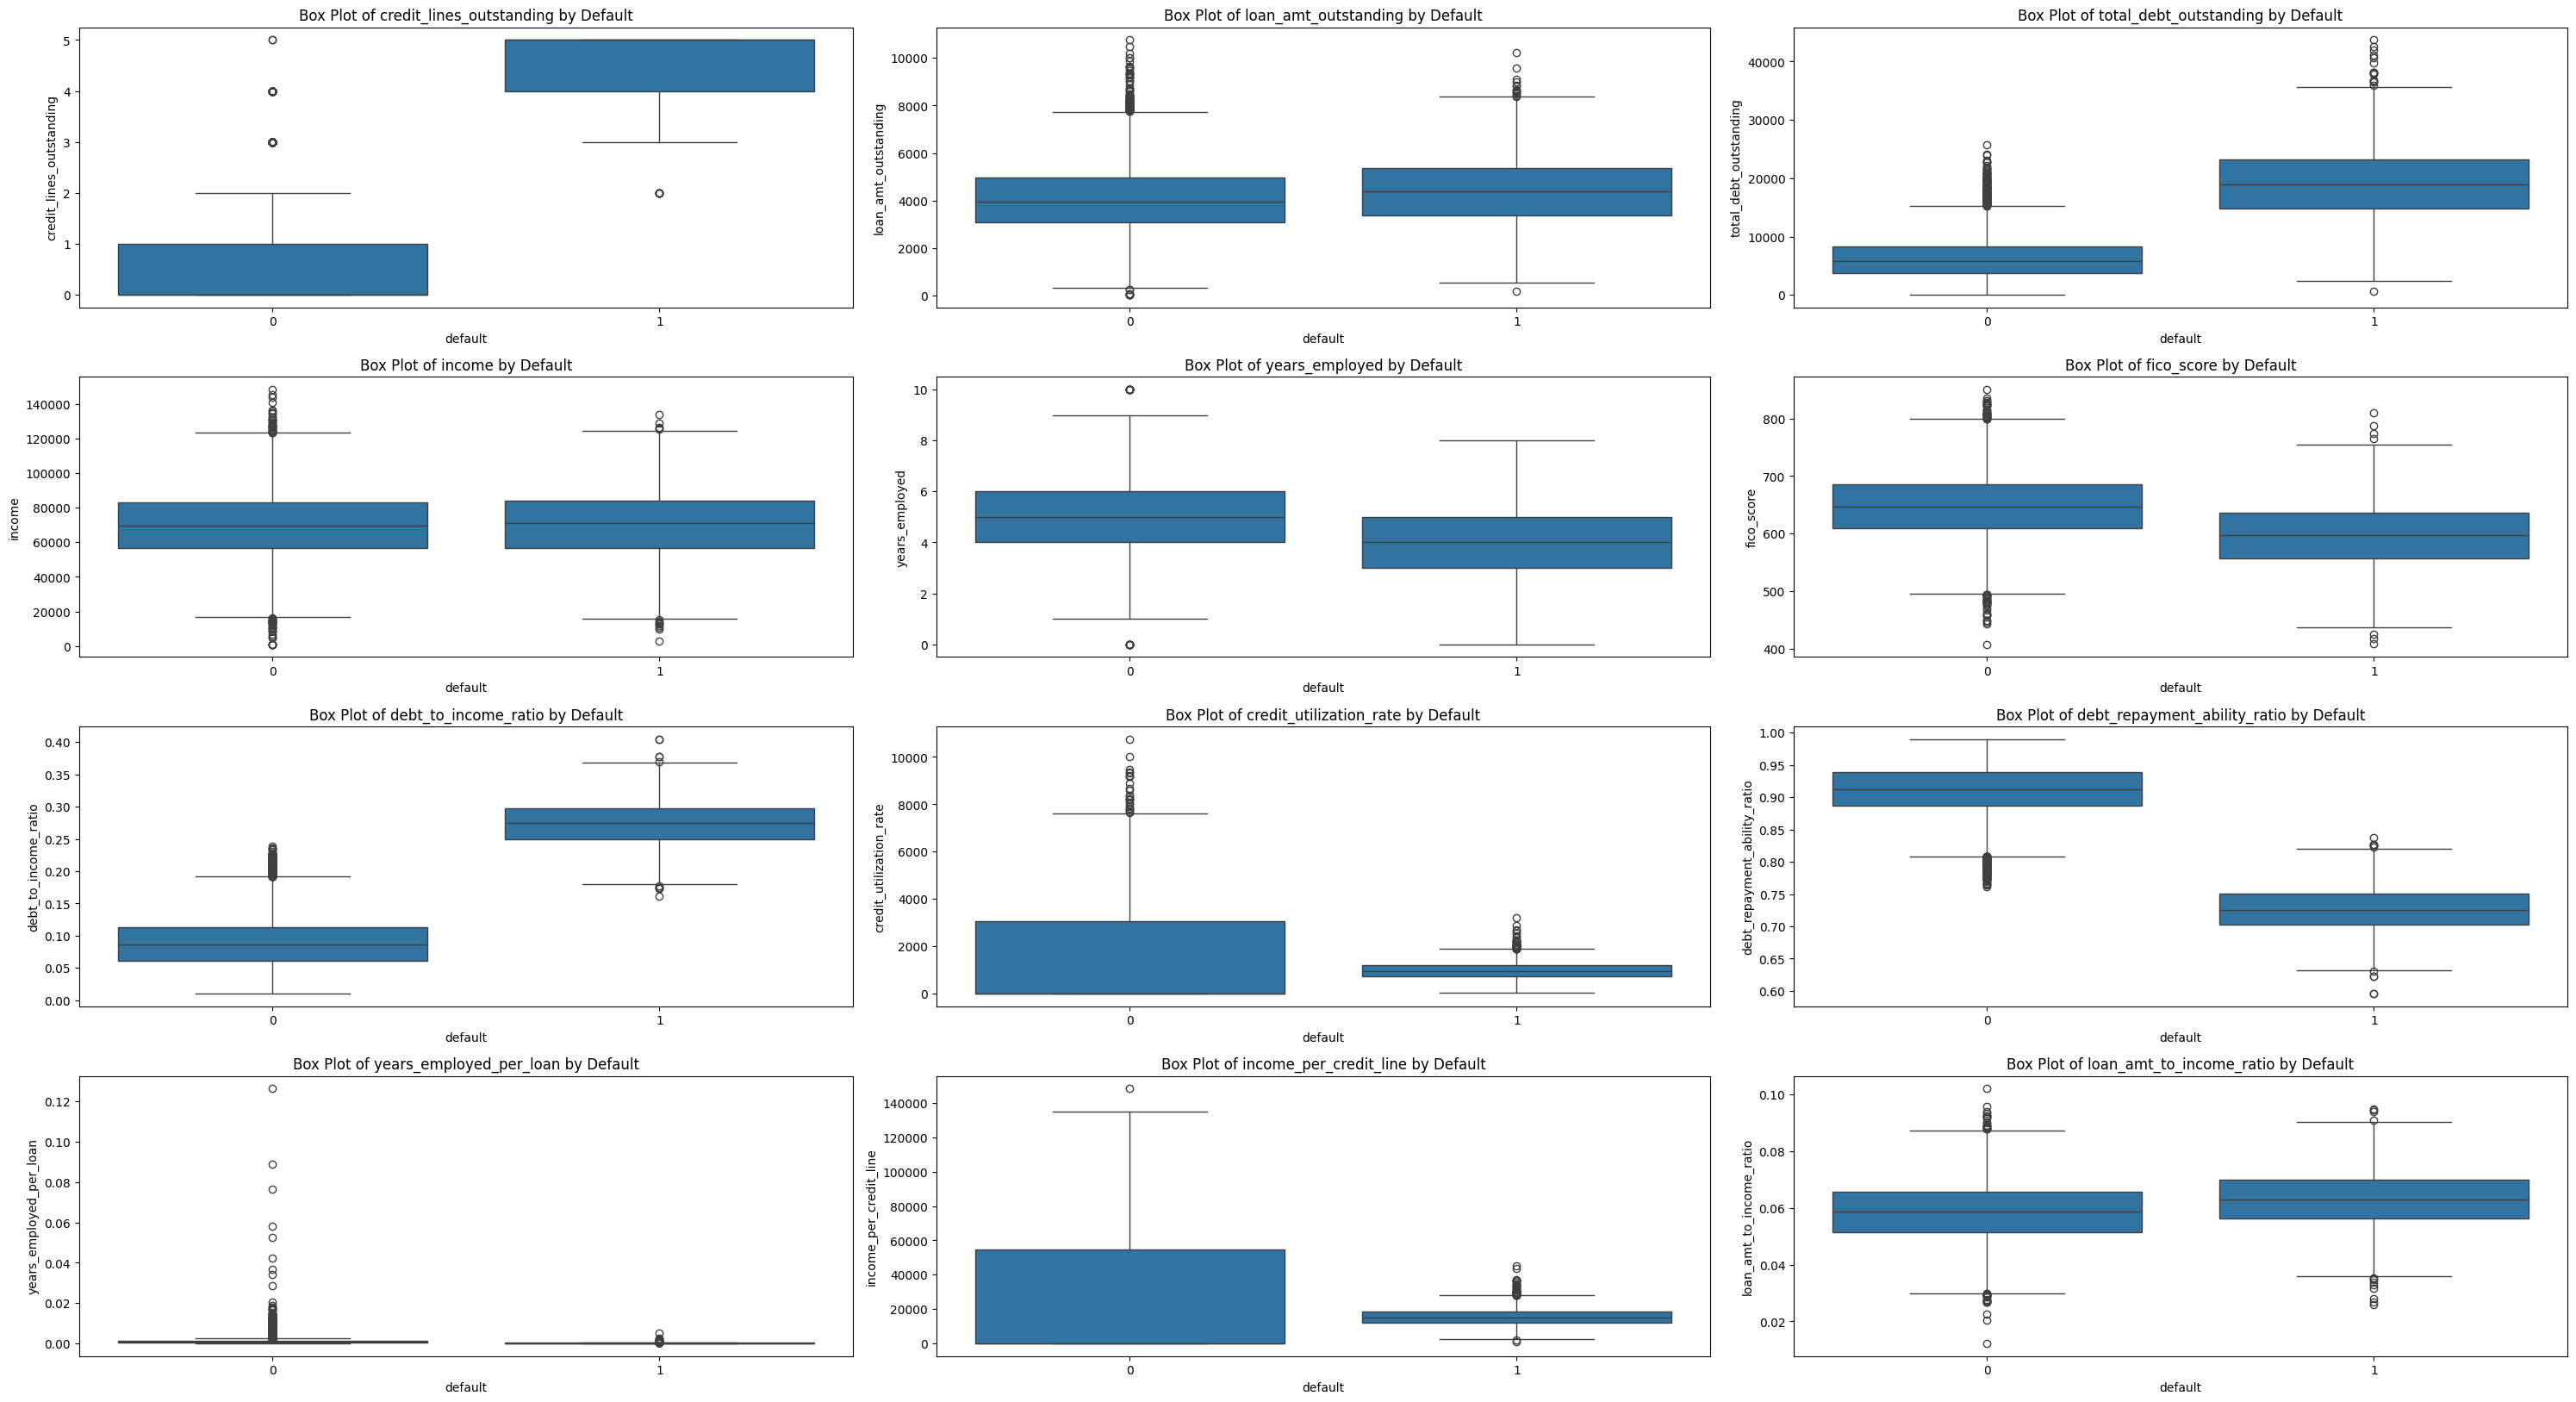

In [223]:
# Plot the box plots to identify which feature is important

import seaborn as sns
# Features needed
features = [
    'credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding',
    'income', 'years_employed', 'fico_score', 'debt_to_income_ratio',
    'credit_utilization_rate', 'debt_repayment_ability_ratio', 'years_employed_per_loan',
    'income_per_credit_line', 'loan_amt_to_income_ratio'
]

plt.figure(figsize=(30, 20))
for i, feature in enumerate(features, 1):
    plt.subplot(5, 3, i)
    sns.boxplot(x='default', y=feature, data=df)
    plt.title(f'Box Plot of {feature} by Default')
plt.tight_layout()
plt.show()

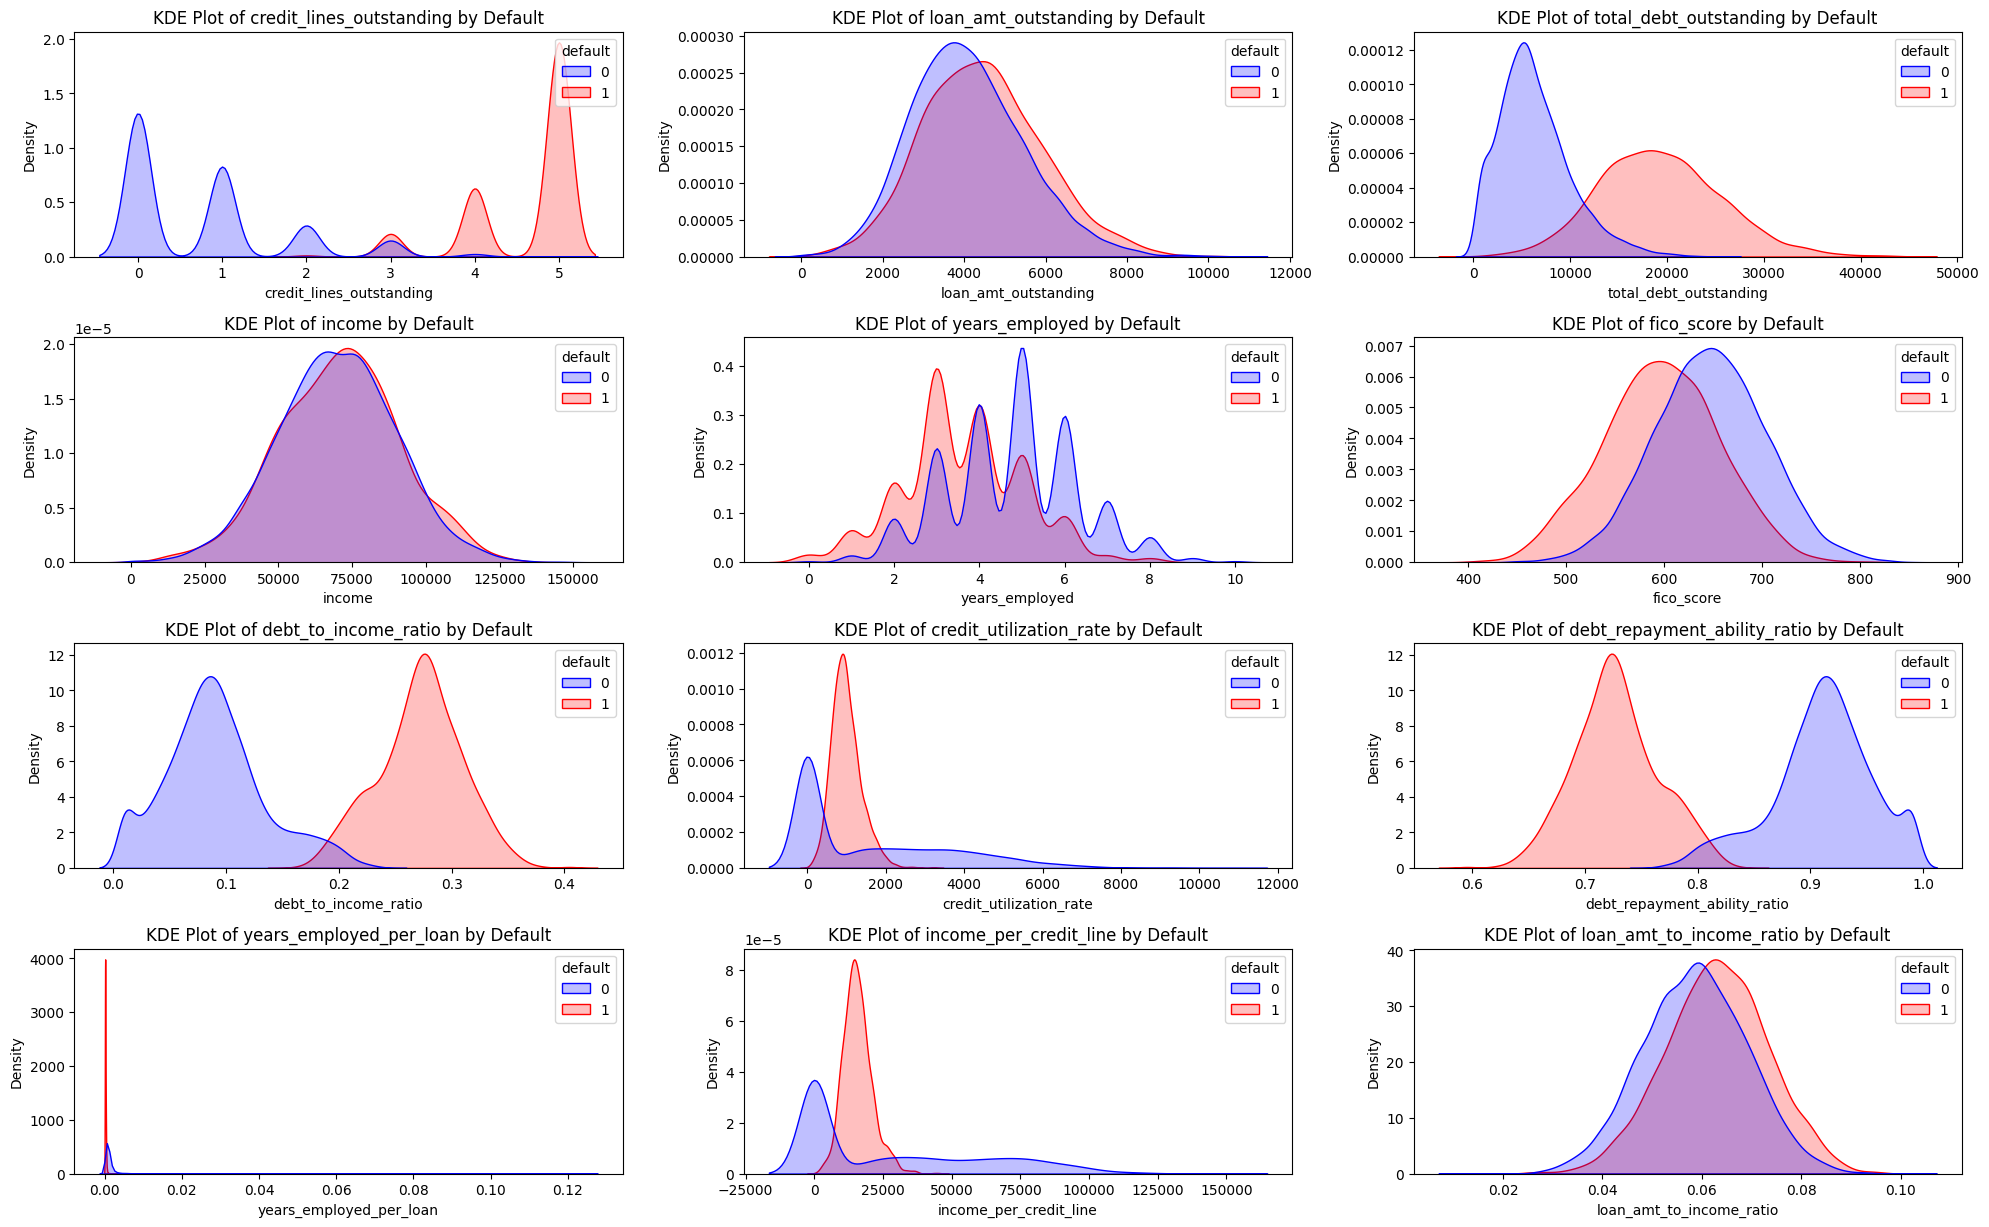

In [224]:
# Define custom colors for each hue
custom_palette = {0: 'blue', 1: 'red'}  # Adjust keys and colors based on your hue values

plt.figure(figsize=(20, 15))
for i, feature in enumerate(features, 1):
    plt.subplot(5, 3, i)
    sns.kdeplot(data=df, x=feature, hue='default', fill=True, common_norm=False, palette=custom_palette)
    plt.title(f'KDE Plot of {feature} by Default')
plt.tight_layout()
plt.show()


In [225]:
from scipy.stats import mannwhitneyu

def compute_mannwhitneyu_pvalue(df, feature, group_col, group1, group2):
    """Compute p-value for the Mann-Whitney U test for a single feature between two groups."""
    data1 = df[df[group_col] == group1][feature].dropna()
    data2 = df[df[group_col] == group2][feature].dropna()

    # Ensure that there are enough data points
    if len(data1) < 2 or len(data2) < 2:
        raise ValueError(f"Insufficient data points for feature '{feature}' in one or both groups.")

    # Perform Mann-Whitney U test
    _, p_value = mannwhitneyu(data1, data2, alternative='two-sided')
    return p_value

# Calculate p-values for each feature using Mann-Whitney U test
p_values_mannwhitneyu = {}
for feature in features:
    try:
        p_value = compute_mannwhitneyu_pvalue(df, feature, group_col, group1, group2)
        p_values_mannwhitneyu[feature] = p_value
    except ValueError as e:
        print(e)
        p_values_mannwhitneyu[feature] = None

# Print p-values
for feature, p_value in p_values_mannwhitneyu.items():
    if p_value is not None:
        print(f'p-value for {feature} (Mann-Whitney U): {p_value}')
    else:
        print(f'p-value for {feature} (Mann-Whitney U): Data insufficient for p-value calculation')


p-value for credit_lines_outstanding (Mann-Whitney U): 0.0
p-value for loan_amt_outstanding (Mann-Whitney U): 2.5953455802511134e-23
p-value for total_debt_outstanding (Mann-Whitney U): 0.0
p-value for income (Mann-Whitney U): 0.09947387894385583
p-value for years_employed (Mann-Whitney U): 1.1555950346061888e-177
p-value for fico_score (Mann-Whitney U): 1.767485899331441e-211
p-value for debt_to_income_ratio (Mann-Whitney U): 0.0
p-value for credit_utilization_rate (Mann-Whitney U): 1.297275175843746e-07
p-value for debt_repayment_ability_ratio (Mann-Whitney U): 0.0
p-value for years_employed_per_loan (Mann-Whitney U): 0.0
p-value for income_per_credit_line (Mann-Whitney U): 0.00022757453254651402
p-value for loan_amt_to_income_ratio (Mann-Whitney U): 1.4755762353035608e-58


In [226]:
from scipy.stats import ks_2samp

def compute_ks_pvalue(df, feature, group_col, group1, group2):
    """Compute p-value for the Kolmogorov-Smirnov test for a single feature between two groups."""
    data1 = df[df[group_col] == group1][feature].dropna()
    data2 = df[df[group_col] == group2][feature].dropna()

    # Ensure that there are enough data points
    if len(data1) < 2 or len(data2) < 2:
        raise ValueError(f"Insufficient data points for feature '{feature}' in one or both groups.")

    # Perform Kolmogorov-Smirnov test
    _, p_value = ks_2samp(data1, data2)
    return p_value

# Calculate p-values for each feature using Kolmogorov-Smirnov test
p_values_ks = {}
for feature in features:
    try:
        p_value = compute_ks_pvalue(df, feature, group_col, group1, group2)
        p_values_ks[feature] = p_value
    except ValueError as e:
        print(e)
        p_values_ks[feature] = None

# Print p-values
for feature, p_value in p_values_ks.items():
    if p_value is not None:
        print(f'p-value for {feature} (Kolmogorov-Smirnov): {p_value}')
    else:
        print(f'p-value for {feature} (Kolmogorov-Smirnov): Data insufficient for p-value calculation')


p-value for credit_lines_outstanding (Kolmogorov-Smirnov): 0.0
p-value for loan_amt_outstanding (Kolmogorov-Smirnov): 2.35453875628056e-19
p-value for total_debt_outstanding (Kolmogorov-Smirnov): 7.46e-322
p-value for income (Kolmogorov-Smirnov): 0.11710118934020525
p-value for years_employed (Kolmogorov-Smirnov): 6.924827660525796e-142
p-value for fico_score (Kolmogorov-Smirnov): 2.8982408914656556e-154
p-value for debt_to_income_ratio (Kolmogorov-Smirnov): 0.0
p-value for credit_utilization_rate (Kolmogorov-Smirnov): 6.507e-321
p-value for debt_repayment_ability_ratio (Kolmogorov-Smirnov): 0.0
p-value for years_employed_per_loan (Kolmogorov-Smirnov): 9.14e-322
p-value for income_per_credit_line (Kolmogorov-Smirnov): 6.51e-321
p-value for loan_amt_to_income_ratio (Kolmogorov-Smirnov): 4.385585899201495e-45


In [227]:
# Drop useless features
df = df.drop(columns = ['income', 'years_employed_per_loan'], errors = 'ignore')

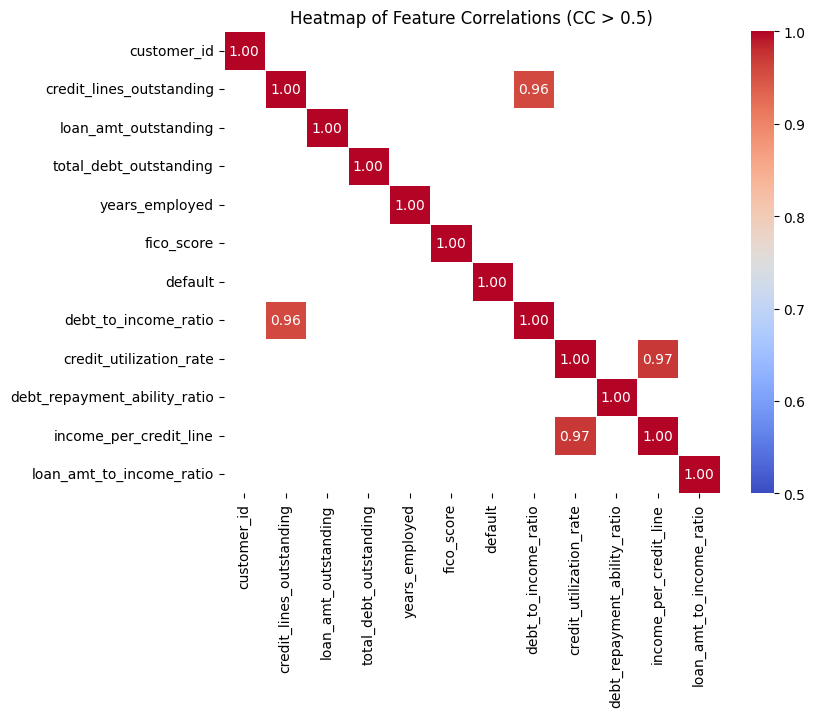

In [228]:
# Multicollinearity check

# Calculate the correlation matrix
corr_matrix = df.corr()

# Create a mask for correlations when VIF is acceptable
mask = np.where(corr_matrix <= np.sqrt(0.8), np.nan, corr_matrix)

# Create the heatmap with masked values and retain column names
plt.figure(figsize=(8, 6))
sns.heatmap(mask, annot=True, cmap='coolwarm', fmt='.2f', vmin=0.5, vmax=1, linewidths=0.5, mask=np.isnan(mask),
            xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)
plt.title('Heatmap of Feature Correlations (CC > 0.5)')
plt.show()



### **Model training and evaluating**

1. Simple logistic regression with regularization (benchmark)

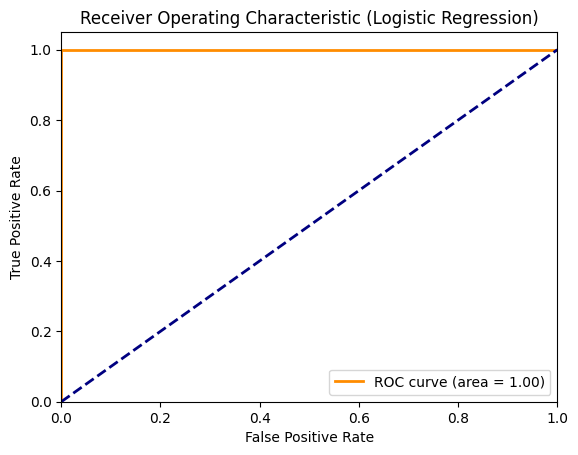

Confusion Matrix:
                 Predicted_Negative  Predicted_Positive
Actual_Negative                 819                   0
Actual_Positive                   0                 181

Scores DataFrame:
   Confusion_Matrix_TP_logistic  Confusion_Matrix_FP_logistic  \
0                           181                             0   

   ROC_AUC_logistic  
0               1.0  


In [229]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Define features and target
X = df.drop(columns = ['default', 'customer_id'])
y = df['default']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the Logistic Regression model
log_reg = LogisticRegression(penalty='l1', solver='liblinear')
log_reg.fit(X_train_scaled, y_train)

# Predict probabilities
y_pred_probs = log_reg.predict_proba(X_test_scaled)[:, 1]

# Convert probabilities to binary outcomes
threshold = 0.5
y_pred_binary = (y_pred_probs > threshold).astype(int)

# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
cm_df = pd.DataFrame(cm, columns=['Predicted_Negative', 'Predicted_Positive'], index=['Actual_Negative', 'Actual_Positive'])

# Compute ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_probs)

# Compute ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)

# Save ROC curve to plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Logistic Regression)')
plt.legend(loc='lower right')
plt.show()

# Save scores to a DataFrame
scores_df = pd.DataFrame({
    'Confusion_Matrix_TP_logistic': [cm[1, 1]],
    'Confusion_Matrix_FP_logistic': [cm[0, 1]],
    'ROC_AUC_logistic': [roc_auc]
})

# Display the confusion matrix and scores DataFrame
print("Confusion Matrix:")
print(cm_df)
print("\nScores DataFrame:")
print(scores_df)


In [230]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the Logistic Regression model with L1 regularization
log_reg = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)

# Perform 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to hold performance metrics
roc_auc_scores = []
conf_matrices = []

for train_index, test_index in cv.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model
    log_reg.fit(X_train, y_train)

    # Predict probabilities
    y_pred_probs = log_reg.predict_proba(X_test)[:, 1]

    # Convert probabilities to binary outcomes
    y_pred_binary = (y_pred_probs > 0.5).astype(int)

    # Compute ROC AUC Score and save it
    roc_auc = roc_auc_score(y_test, y_pred_probs)
    roc_auc_scores.append(roc_auc)

    # Compute Confusion Matrix and save it
    cm = confusion_matrix(y_test, y_pred_binary)
    conf_matrices.append(cm)

# Calculate mean and variance of ROC AUC scores
mean_roc_auc = np.mean(roc_auc_scores)
var_roc_auc = np.var(roc_auc_scores)

# Calculate mean and variance of confusion matrices
mean_cm = np.mean(conf_matrices, axis=0)
var_cm = np.var(conf_matrices, axis=0)

# Display results
print("ROC AUC Scores (10-fold CV):", roc_auc_scores)
print("Mean ROC AUC Score:", mean_roc_auc)
print("Variance of ROC AUC Score:", var_roc_auc)

print("\nMean Confusion Matrix (10-fold CV):")
print(mean_cm)
print("\nVariance of Confusion Matrix (10-fold CV):")
print(var_cm)


ROC AUC Scores (10-fold CV): [1.0, 1.0, 0.9999734704029183, 0.9999933676007295, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999933951546854]
Mean ROC AUC Score: 0.9999960233158334
Variance of ROC AUC Score: 6.33292053415467e-11

Mean Confusion Matrix (10-fold CV):
[[8.149e+02 0.000e+00]
 [7.000e-01 1.844e+02]]

Variance of Confusion Matrix (10-fold CV):
[[0.09 0.  ]
 [0.61 0.44]]


XGB Regression model

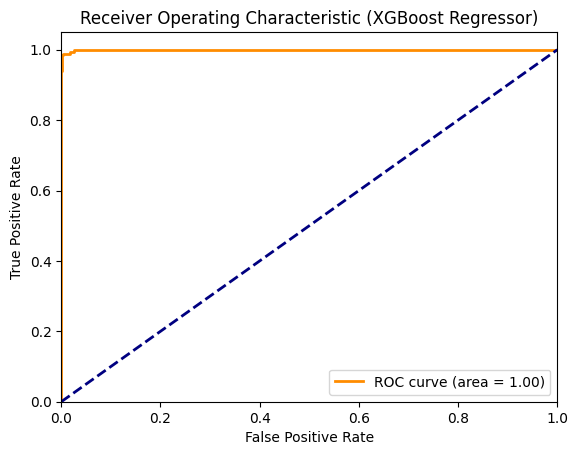

Confusion Matrix:
                 Predicted_Negative  Predicted_Positive
Actual_Negative                 813                   1
Actual_Positive                   3                 183

Scores DataFrame:
   Confusion_Matrix_TP_xgb  Confusion_Matrix_FP_xgb  ROC_AUC_xgb
0                      183                        1     0.999696


In [246]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import xgboost as xgb

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the XGBoost Regressor model
xgb_reg = xgb.XGBRegressor(
    reg_alpha=0.2,  # L1 regularization term on weights
    reg_lambda=1.0,  # L2 regularization term on weights
    random_state=42
)
xgb_reg.fit(X_train_scaled, y_train)

# Predict probabilities
y_pred_probs = xgb_reg.predict(X_test_scaled)

# Convert probabilities to binary outcomes
threshold = 0.5
y_pred_binary = (y_pred_probs > threshold).astype(int)

# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
cm_df = pd.DataFrame(cm, columns=['Predicted_Negative', 'Predicted_Positive'], index=['Actual_Negative', 'Actual_Positive'])

# Compute ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_probs)

# Compute ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)

# Save ROC curve to plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (XGBoost Regressor)')
plt.legend(loc='lower right')
plt.show()

# Save scores to a DataFrame
scores_df = pd.DataFrame({
    'Confusion_Matrix_TP_xgb': [cm[1, 1]],
    'Confusion_Matrix_FP_xgb': [cm[0, 1]],
    'ROC_AUC_xgb': [roc_auc]
})

# Display the confusion matrix and scores DataFrame
print("Confusion Matrix:")
print(cm_df)
print("\nScores DataFrame:")
print(scores_df)


MLP model

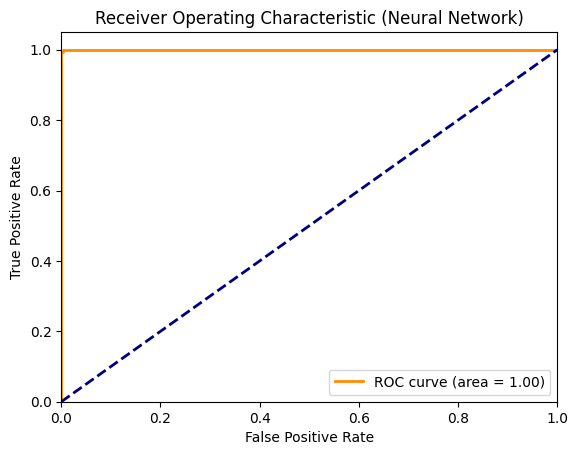

Confusion Matrix:
                 Predicted_Negative  Predicted_Positive
Actual_Negative                 814                   0
Actual_Positive                   1                 185

Scores DataFrame:
   Confusion_Matrix_TP_nn  Confusion_Matrix_FP_nn  ROC_AUC_nn
0                     185                       0     0.99998


In [253]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier

# Initialize and train the MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000, random_state=42, alpha=0.1)
mlp.fit(X_train_scaled, y_train)

# Predict probabilities
y_pred_probs = mlp.predict_proba(X_test_scaled)[:, 1]

# Convert probabilities to binary outcomes
threshold = 0.5
y_pred_binary = (y_pred_probs > threshold).astype(int)

# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
cm_df = pd.DataFrame(cm, columns=['Predicted_Negative', 'Predicted_Positive'], index=['Actual_Negative', 'Actual_Positive'])

# Compute ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_probs)

# Compute ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)

# Save ROC curve to plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Neural Network)')
plt.legend(loc='lower right')
plt.show()

# Save scores to a DataFrame
scores_df = pd.DataFrame({
    'Confusion_Matrix_TP_nn': [cm[1, 1]],
    'Confusion_Matrix_FP_nn': [cm[0, 1]],
    'ROC_AUC_nn': [roc_auc]
})

# Display the confusion matrix and scores DataFrame
print("Confusion Matrix:")
print(cm_df)
print("\nScores DataFrame:")
print(scores_df)
